In [122]:
import pandas as pd
dataset = pd.read_csv(r'C:\Users\mtsil\Desktop\german_essays.csv', encoding='unicode_escape')

In [123]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset.head(2)

,rater,thema,i_1,i_2,i_3,i_4,t_1,t_2,t_3,sr_1,sr_2,sr_3,sr_4,sa_1,sa_2,sa_3,sa_4,id_text,wle_dsch,sewle_dsch,punkte_dsch,sumscore,essay
0,9,1,2,2,1,1,0,2,1,2,1,2,2,2,2,1,2,K011_001,0.450426,0.551269,822.0,23,"Ich möchte gern in Spanien wohnen, am besten i..."
1,9,1,2,2,1,2,1,2,2,2,1,3,2,2,2,1,2,K011_002,1.651275,0.553108,916.0,27,Ich würde gerne in einem Haus leben. Es sollte...


In [124]:
# create df1 to store the essay variable

df1 = dataset['essay']

In [125]:
# add the values of the cohesion across each row; the sum score is stored in the df2 pandas data frame

pd.set_option('display.max_rows', None)
df2 = dataset[['t_1', 't_2', 't_3']].agg(['sum'], axis=1)
df2.head(2)

,sum
0,3
1,5


In [126]:
# concatenate df1 and df2 into a new pandas data frame called cohesion
# the last three rows do not contain any values for the essay variable

cohesion = pd.concat([df1, df2], axis=1)
cohesion.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",3
1,Ich würde gerne in einem Haus leben. Es sollte...,5


In [127]:
# drop the last three rows and create the final pandas data frame called final_cohesion

final_cohesion = cohesion.drop([125, 126, 127])
final_cohesion.shape

(125, 2)

In [128]:
# check the distribution of the values for the cohesion criterion

final_cohesion[['sum']].value_counts()

sum
3      36
4      35
5      29
2      23
0       1
1       1
Name: count, dtype: int64

In [129]:
from sklearn.preprocessing import KBinsDiscretizer

# Quantile Discretization

quantile_discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
final_cohesion['sum'] = quantile_discretizer.fit_transform(final_cohesion[['sum']])

final_cohesion.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",0.0
1,Ich würde gerne in einem Haus leben. Es sollte...,1.0


In [130]:
final_cohesion['sum'] = final_cohesion['sum'].astype(int)
final_cohesion.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",0
1,Ich würde gerne in einem Haus leben. Es sollte...,1


In [131]:
final_cohesion['sum'].value_counts(ascending = True)

sum
0    61
1    64
Name: count, dtype: int64

In [132]:
X = final_cohesion['essay']
y = final_cohesion['sum']

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 6000)
X = td.fit_transform(X).toarray()

In [134]:
# no need for the parameter test_size becauseone-third of the data it is set aside as test data, known as the out-of-bag (oob) sample 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     random_state=0, 
                                                    shuffle=True)

In [135]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.96875, 1: 1.0333333333333334}

In [140]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, class_weight= class_weights, max_features = 'log2', min_samples_split = 3, min_samples_leaf = 3, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)


RandomForestClassifier(class_weight={0: 0.96875, 1: 1.0333333333333334},
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [141]:
predictions = model.predict(X_test)

In [138]:
from sklearn.metrics import accuracy_score

In [142]:
print(f'Training set accuracy: {model.score(X_train, y_train):.4f}')
print(f'Test set accuracy: {model.score(X_test, y_test):.4f}')

Training set accuracy: 0.9247
Test set accuracy: 0.8438


In [143]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.85      0.89      0.87        19

    accuracy                           0.84        32
   macro avg       0.84      0.83      0.84        32
weighted avg       0.84      0.84      0.84        32



In [144]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,predictions)

<Axes: >

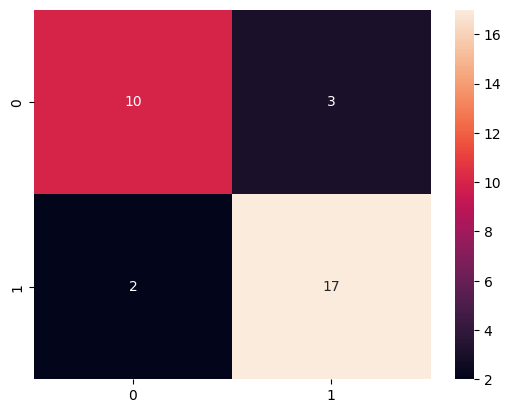

In [145]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='.2g')

In [147]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.8785425101214575

In [148]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions)

0.6721311475409837

In [149]:
import joblib 


filename = 'joblib_model.sav'
joblib.dump(model, filename)

['joblib_model.sav']

In [151]:
loaded_model = joblib.load(filename)

In [152]:
loaded_model

RandomForestClassifier(class_weight={0: 0.96875, 1: 1.0333333333333334},
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [153]:
y_predict = model.predict(X_test)

In [154]:
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.85      0.89      0.87        19

    accuracy                           0.84        32
   macro avg       0.84      0.83      0.84        32
weighted avg       0.84      0.84      0.84        32

